# 隠れ2層ver

In [50]:
# 必要なライブラリのインポート
import numpy as np          # 数値計算ライブラリ
import matplotlib.pyplot as plt    # グラフ描画ライブラリ
import torch                 # 機械学習ライブラリPyTorch
from torch import nn        # PyTorchのニューラルネットワークモジュール
from torchviz import make_dot      # PyTorchのグラフ可視化ツール
import japanize_matplotlib  # matplotlibの日本語表示を可能にするライブラリ
import torch.optim as optim # PyTorchの最適化アルゴリズムを定義するoptimモジュール
import pandas as pd         # データフレーム処理のためのライブラリ
import sklearn              # 機械学習ライブラリscikit-learn
from torchinfo import summary   # モデルのサマリー情報を表示するためのライブラリ
from sklearn.model_selection import train_test_split  # データのトレーニングとテストの分割を行う関数
from sklearn.metrics import accuracy_score   # 正解率を計算するための関数

In [51]:
#  GPUが利用可能かチェックし、使用できる場合はデバイスにセット
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [52]:
# データ変換用関数Transform
import torchvision.transforms as transforms

# (1) ToTensor() : PIL形式の画像をPyTorchのテンソルに変換
# (2) Normalize() : [0,1]の範囲の画像を[-1,1]の範囲に正規化
# (3) Lambda() : 1つ1つのデータを[1,28,28]から[784]に変換
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Lambda(lambda x: x.view(-1))])

# transformを用いてデータセットを作成

# MNIStデータセットのダウンロード
import torchvision.datasets as datasets

data_root = "./mnist_data"

# 訓練データセットを定義
train_set = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)

# 検証データセットを定義
test_set = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

In [53]:
# データローダーを定義
from torch.utils.data import DataLoader

# ミニバッチサイズ
batch_size = 500

# 訓練データセットのデータローダーを定義
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# 検証データセットのデータローダーを定義
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [54]:
# モデルの定義
class Net(nn.Module):
    def __init__(self,n_input,n_hidden,n_output):
        super().__init__()
        
        # 隠れ層1の定義
        self.l1 = nn.Linear(n_input,n_hidden)

        # 隠れ層2の定義
        self.l2 = nn.Linear(n_hidden,n_hidden)

        # 出力層の定義

        self.l3 = nn.Linear(n_hidden,n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)

    def forward(self,x):
        # 隠れ層1の計算
        h1 = self.l1(x)
        h1 = self.relu(h1)

        # 隠れ層2の計算
        h2 = self.l2(h1)
        h2 = self.relu(h2)

        # 出力層の計算
        y = self.l3(h2)

        return y
        

In [55]:
# 入力次元数
image,_ = train_set[0]
n_input = image.shape[0]

# 出力次元数=分類先のクラス数
n_output = len(train_set.classes)

# 中間層の次元数
n_hidden = 128

# 乱数の固定
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# モデルのインスタンス化
net = Net(n_input,n_hidden,n_output)

# モデルをGPUに転送
net = net.to(device)

In [56]:
# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズムの定義
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 学習回数
n_epoch = 100

# 評価結果を格納するリスト(エポック数、訓練データの損失、テストデータの損失、訓練データの正解率、テストデータの正解率)
history = np.zeros((0,5))


In [57]:
# tqdmを使って進捗状況を表示
from tqdm import tqdm


# 繰り返し処理
for epoch in range(n_epoch):
    # 初期化
    train_loss , train_acc , test_loss , test_acc = 0 , 0 , 0 , 0
    n_train , n_test = 0 , 0

    # 訓練モードに設定
    net.train()
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        # GPUに転送
        images = images.to(device)
        labels = labels.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        outputs = net(images)

        # 損失の計算
        loss = criterion(outputs, labels)

        # 逆伝播
        loss.backward()

        # パラメータの更新
        optimizer.step()

        # 訓練データの損失の合計を更新
        train_loss += loss.item()

        # 訓練データの正解数の合計を更新
        train_acc += (outputs.max(1)[1] == labels).sum().item()

        # 訓練データの個数を更新
        n_train += len(labels)

    # 訓練データの正解率を計算
    train_acc /= n_train

    # 検証モードに設定
    net.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(test_loader)):
            # GPUに転送
            images = images.to(device)
            labels = labels.to(device)

            # 順伝播
            outputs = net(images)

            # 損失の計算
            loss = criterion(outputs, labels)

            # 検証データの損失の合計を更新
            test_loss += loss.item()

            # 検証データの正解数の合計を更新
            test_acc += (outputs.max(1)[1] == labels).sum().item()

            # 検証データの個数を更新
            n_test += len(labels)
    # 検証データの正解率を計算
    test_acc /= n_test

    # 評価結果を格納
    history = np.vstack((history, np.array([epoch, train_loss, test_loss, train_acc, test_acc])))

100%|██████████| 20/20 [00:01<00:00, 15.95it/s]


In [58]:
# 評価結果を表示
print(f'初期損失 : {history[0,1]:.4f} -> 最終損失 : {history[-1,1]:.4f}')
print(f'初期正解率 : {history[0,3]:.4f} -> 最終正解率 : {history[-1,3]:.4f}')

初期損失 : 264.1955 -> 最終損失 : 15.7127
初期正解率 : 0.2538 -> 最終正解率 : 0.9629


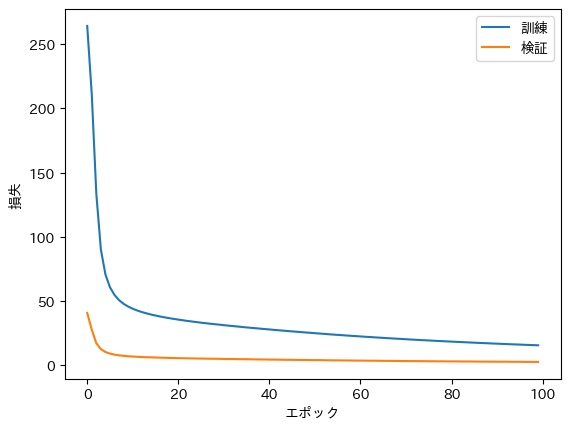

In [59]:
# 学習曲線(損失)の表示
plt.plot(history[:,0], history[:,1], label='訓練')
plt.plot(history[:,0], history[:,2], label='検証')
plt.xlabel('エポック')
plt.ylabel('損失')
plt.legend()
plt.show()


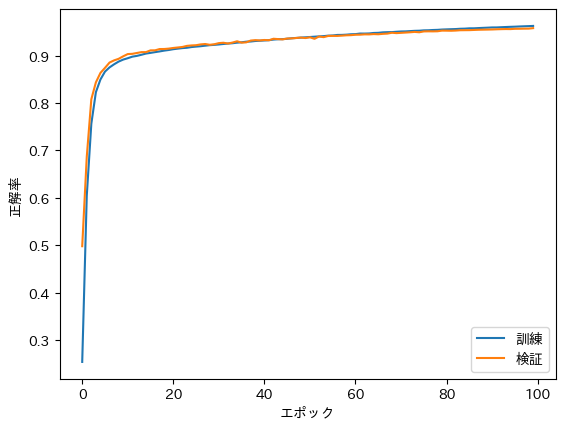

In [60]:
# 学習曲線(正解率)の表示
plt.plot(history[:,0], history[:,3], label='訓練')
plt.plot(history[:,0], history[:,4], label='検証')
plt.xlabel('エポック')
plt.ylabel('正解率')
plt.legend()
plt.show()